In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr

matplotlib.rcParams.update({'font.size': 14})
import dedalus.public as d3

import logging
logging.disable()

In [11]:
import sys
sys.path.append("../../src/")
from bfzi.helpers import *
from bfzi.linear_instability import *

In [12]:
n_wavenumbers = 100; wavenumbers = 10. **np.linspace(np.log10(3.e-5), np.log10(3.e-3), n_wavenumbers)

In [13]:
reference_friction = {
    "κ0":1.e-7, "κ1":0., "νh":0.1, "ν4":2.e4,
}

## Sensitivity of growth rate $\Im\{\omega\}$ and instability scale $\lambda_{\text{max}}$ to frontal strength $Ri$ (equivalently, $M$)

In [14]:
Riref = 10.
Mref = calc_M_from_Ri(Riref, N, f, θ)
Lref = calc_Lmax(calc_Nbfz(N, Mref, θ), Hbfz, f, Riref)

In [15]:
Ris = np.logspace(0., 3., 7)
Ms = calc_M_from_Ri(Ris, N, f, θ)
gr = xr.DataArray(np.zeros((n_wavenumbers, Ris.size)), coords={'wavenumber':wavenumbers, 'Ri':Ris,})
for Ri, M in zip(Ris, Ms):
    print(f"Ri = {Ri}", end=", ")
    for n in wavenumbers:
        L = calc_Lmax(calc_Nbfz(N, M, θ), Hbfz, f, calc_Ri(N, M, θ, f))
        bfzi = bottom_frontal_zone_instability(
            0., 2*np.pi*n, M,
            κ0=reference_friction["κ0"], κ1=reference_friction["κ1"],
            νh=reference_friction["νh"]*(L/Lref)**2,
            ν4=reference_friction["ν4"]*(L/Lref)**4
        )
        gr = gr.where(~((gr.Ri==Ri) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)
gr.to_netcdf("../../data/growth_rates/Ri_dependence_frictional.nc")

Ri = 1.0, Ri = 3.1622776601683795, Ri = 10.0, Ri = 31.622776601683793, Ri = 100.0, Ri = 316.22776601683796, Ri = 1000.0, 

In [16]:
gr = xr.DataArray(np.zeros((n_wavenumbers, Ris.size)), coords={'wavenumber':wavenumbers, 'Ri':Ris,})
for Ri, M in zip(Ris, Ms):
    print(f"Ri = {Ri}", end=", ")
    for n in wavenumbers:
        L = calc_Lmax(calc_Nbfz(N, M, θ), Hbfz, f, calc_Ri(N, M, θ, f))
        bfzi = bottom_frontal_zone_instability(
            0., 2*np.pi*n, M,
            κ0=reference_friction["κ0"], κ1=reference_friction["κ1"],
            νh=0.,
            ν4=0.
        )
        gr = gr.where(~((gr.Ri==Ri) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)
gr.to_netcdf("../../data/growth_rates/Ri_dependence_inviscid.nc")

Ri = 1.0, Ri = 3.1622776601683795, Ri = 10.0, Ri = 31.622776601683793, Ri = 100.0, Ri = 316.22776601683796, Ri = 1000.0, 

## Sensitivity to frictional parameters ($\nu, \kappa, \nu_{h}, \kappa_{h}, \nu_{4}, \kappa_{4}$)

In [17]:
Ri = Riref
M = calc_M_from_Ri(Ri, N, f, θ)

gr = xr.Dataset()
gr.attrs["Ri"] = Ri
gr.attrs["M"] = M
friction_scalings = np.array([1.e-2, 1e-1, 1.e0, 1e1, 1.e2])

##### Inviscid control

In [18]:
gr['inviscid'] = xr.DataArray(np.zeros((n_wavenumbers,)), coords={'wavenumber':wavenumbers,})
for n in wavenumbers:
    bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ0=0., κ1=0.)
    gr['inviscid'] = gr['inviscid'].where(~(gr.wavenumber==n), bfzi['omega'][bfzi['idx']].imag)

##### Only background slope-normal diffusivity and viscosity

In [19]:
gr['k0'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ0=reference_friction["κ0"]*sc, κ1=0.)
        gr['k0'] = gr['k0'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

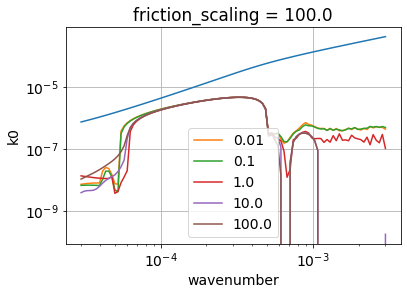

In [20]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['k0'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()
plt.grid(True)

##### Variable horizontal Laplacian viscosity

In [21]:
gr['nuh'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(
            0., 2*np.pi*n, M,
            κ0=reference_friction["κ0"], κ1=reference_friction["κ1"], νh=reference_friction["νh"]*sc
        )
        gr['nuh'] = gr['nuh'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

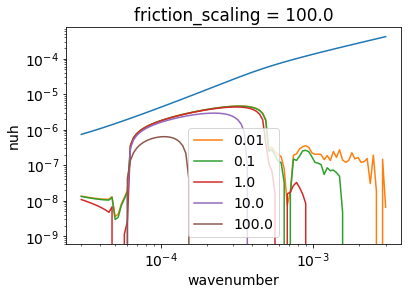

In [22]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['nuh'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

##### Variable horizontal hyper-viscosity (w/ background diffusivities)

In [23]:
gr['nu4'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(
            0., 2*np.pi*n, M,
            κ0=reference_friction["κ0"], κ1=reference_friction["κ1"], ν4=reference_friction["ν4"]*sc
        )
        gr['nu4'] = gr['nu4'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

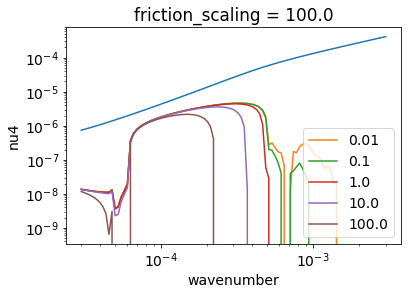

In [24]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['nu4'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

### Saving calculations for post-processing

In [25]:
gr.to_netcdf("../../data/growth_rates/Ri=10_frictional_dependence.nc")